# Drivable Area Detection Project
  -> Course: https://courses.thinkautonomous.ai/image-segmentation
### Project Flow
1. Data Collection 
2. Model Definition
3. Model Training
4. Model Prediction on Real time/Saved video Feed

### Connecting to Google Drive

In [ ]:
import os
from google.colab import drive
from glob import glob
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/My Drive/Computer_Vision_TAI/datasets/")
os.listdir()

['videos.zip',
 'dataset_original.zip',
 'dataset.zip',
 'videos',
 'dataset_original',
 'dataset']

#### Dont execute the below lines except you want to unzip 

In [ ]:
# # Unzip if the files are not unpacked
# listzipfiles = [i  for i in  glob("*") if "zip" in i]
# print(listzipfiles)

['videos.zip', 'dataset_original.zip', 'dataset.zip']


In [ ]:
# for i in tqdm(listzipfiles):
#   temp_folder = i.split(".")[0]
#   os.system("mkdir {}".format(temp_folder))
#   temp_cmd = "unzip {} -d {} ".format(i, temp_folder) 
#   os.system(temp_cmd)

100%|██████████| 3/3 [09:49<00:00, 196.34s/it]


#### Check Tensorflow Version and GPU Specifications

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
!nvidia-smi

Tue Jan 25 20:34:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### For faster process
#### Copying data to local space - Save time on epochs spending lesser time here

# <a name="Data"></a>1. Data Collection --> Visualization --> Processing

This project will use the [BDD 100K Dataset](https://bdd-data.berkeley.edu/).<p>

It was downloaded from [this website](https://bdd-data.berkeley.edu/login.html) and then dumped into a pickle file.<p>-<p>

If you want to repeat the process, go to the [download page](https://bdd-data.berkeley.edu/portal.html#download) (once logged in) and click on the buttons **Images** and **Driverable Maps** under the BDD100K section.
It will download the necessary dataset. Then pick a subset of it.
Use Google Chrome and in case it doesn't work, hit the button again until it does.<p>-<p>


**Use the provided pickle file**<p>
I have downloaded the images and labels. It took a few hours.<p>
I selected **3,000 images** and **their associated labels** and put them into **2 separate pickle files**. <p>Each image has been resized to **160x80** for memory reasons. <p>
**Original 1280x720** images are also available in the course.

<p>-<p>In this part you will load the dataset and adapt it so it fits your neural network.

In [ ]:
### Data Loading and Visualisation libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle

In [ ]:
## Dataset Path configuration Code block

In [ ]:
# Dataset path:
base_path = "./dataset/dataset/"

In [ ]:
## Load Pickle Files
with open(base_path+"images_3000_160.p", 'rb') as f:
  images = pickle.load(f)

with open(base_path+"labels_3000_160.p", 'rb') as f:
  labels = pickle.load(f)


#### Display a Random Image and Label

Text(0.5, 1.0, 'Label')

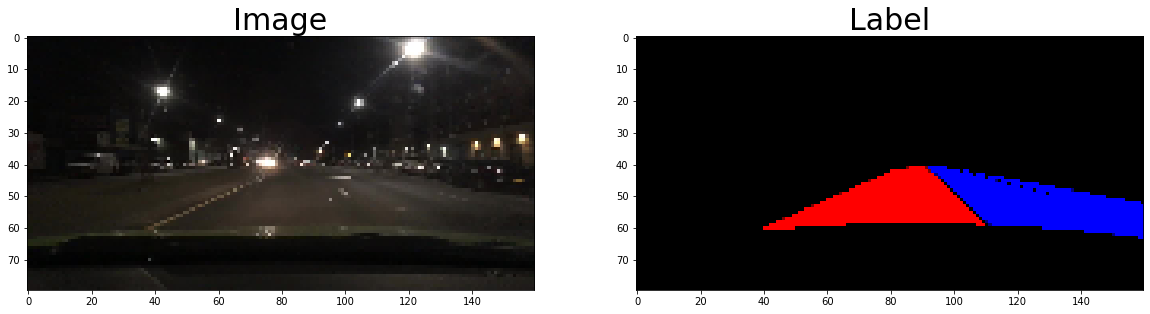

In [ ]:
import random
index = random.randint(0,len(labels))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(images[index].squeeze())
ax1.set_title('Image', fontsize=30)
ax2.imshow(labels[index].squeeze())
ax2.set_title('Label', fontsize=30)

In [ ]:
print("There are "+ str(len(images))+ " images and "+ str(len(labels)) +" labels in the dataset")
print("Shape of an image")
print(images[0].shape)
print("Shape of a Label")
print(labels[0].shape)
print("Images range from "+str(np.amin(images[0]))+" to "+str(np.amax(images[0])))
print("Labels range from "+str(np.amin(labels[0]))+" to "+str(np.amax(labels[0])))

There are 3000 images and 3000 labels in the dataset
Shape of an image
(80, 160, 3)
Shape of a Label
(80, 160, 3)
Images range from 0 to 255
Labels range from 0.0 to 1.0


To fit an Encoder-Decoder Neural Network; you will need to preprocess your labels. Currently, **your labels are RGB images of dimension 160x80x3.**

As you can see here, we have multiple options, and I will detail all 3 of them.

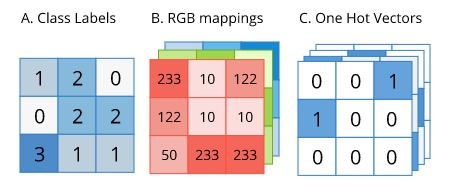

*   **A- Class Labels**
Each Pixel is a number representing a class.<p>
In this case, the output is simply a matrix of 1 channel with these numbers.
*   **B- RGB Mappings**
This is what we currently have, the labels are in RGB format.<p>
As we are only working with 2 classes, and they all are colored either red or blue, it's quite easy to work with.
If you ever get more classes, let's say 7, some pixels will not be 0 or 255, they will have some intensity value and it will get more complicated.
Preprocessing is therefore necessary.
*   **C- One Hot Vectors**
Similar to format A, but one-hot encoded.

### Our choice here
For this project, we are trying to detect only the driveable area or the driveable area + the adjacent lines

Therefore
* Remove every blue pixel and face a 1- channel problem (driveable area detection)
* Keep the blue pixel , use 3 channels.
Convert the black pixels to Green. Then the network have to classify each pixel as Green (Background), Red (Driveable Area), Blue (Adjacent Area)

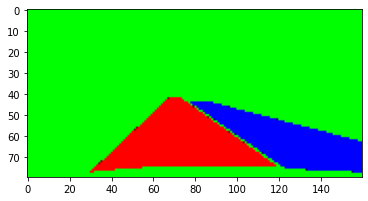

In [ ]:
new_labels = []
for lab in labels:
    for x in range(lab.shape[0]):
        for y in range(lab.shape[1]):
            if (np.all(lab[x][y]==[0,0,0])):
                lab[x][y]=[0,1,0]
    new_labels.append(lab)

plt.imshow(new_labels[0])

### Data Augmentation
As we're only collecting subset of data even though 3000 is a fair number for experimentation

6000
6000


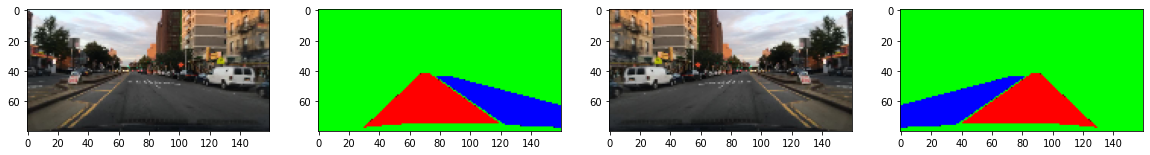

In [ ]:
def flip_image(img):
    return cv2.flip(img, 1)

flipped_images = []
flipped_labels = []

for i in images:
    flipped_images.append(flip_image(i))

for i in labels:
    flipped_labels.append(flip_image(i))

images.extend(flipped_images)
new_labels.extend(flipped_labels)
print(len(images))
print(len(new_labels))

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,10))
ax1.imshow(images[0])
ax2.imshow(new_labels[0])
ax3.imshow(flipped_images[0])
ax4.imshow(flipped_labels[0])

In [ ]:
### To Do
### Use Augmentor to add more noisy images etc.

In [ ]:
## Train test split
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
images = np.array(images)
labels = np.array(new_labels)

# Shuffle
images, labels = shuffle(images, labels)

# Test size may go from 10% to 30%
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.15)
n_train = len(X_train)
n_val = len(X_val)

print("Number of element in training set")
print(n_train)
print("Number of element in validation set")
print(n_val)

Number of element in training set
5100
Number of element in validation set
900


### Deep Learning Modelling

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, Dropout, Conv2D, MaxPooling2D, Reshape, Input, add
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [ ]:
# Functional Keras approach
def encoder_decoder_1(input_shape=(80,160,3), pool_size=(2,2)):
  input = Input(shape=input_shape)
  x = BatchNormalization(input_shape=input_shape)(input)
  x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x1 = BatchNormalization()(x)
  x = MaxPooling2D(pool_size=pool_size)(x1)
  x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x2 = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = MaxPooling2D(pool_size=pool_size)(x2)
  x = Conv2D(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x = BatchNormalization()(x)
  x3 = Dropout(0.2)(x)
  x = add([x3, x])
  x = MaxPooling2D(pool_size=pool_size)(x3)
  x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
  x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
  x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x = add([x2, x])
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
  x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(3, (1,1), padding='valid', strides=(1,1), activation='softmax')(x)
  return Model(input,x)

In [ ]:
model = encoder_decoder_1()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 160, 3)  12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 78, 158, 32)  896         ['batch_normalization[0][0]']    
                                                                                              

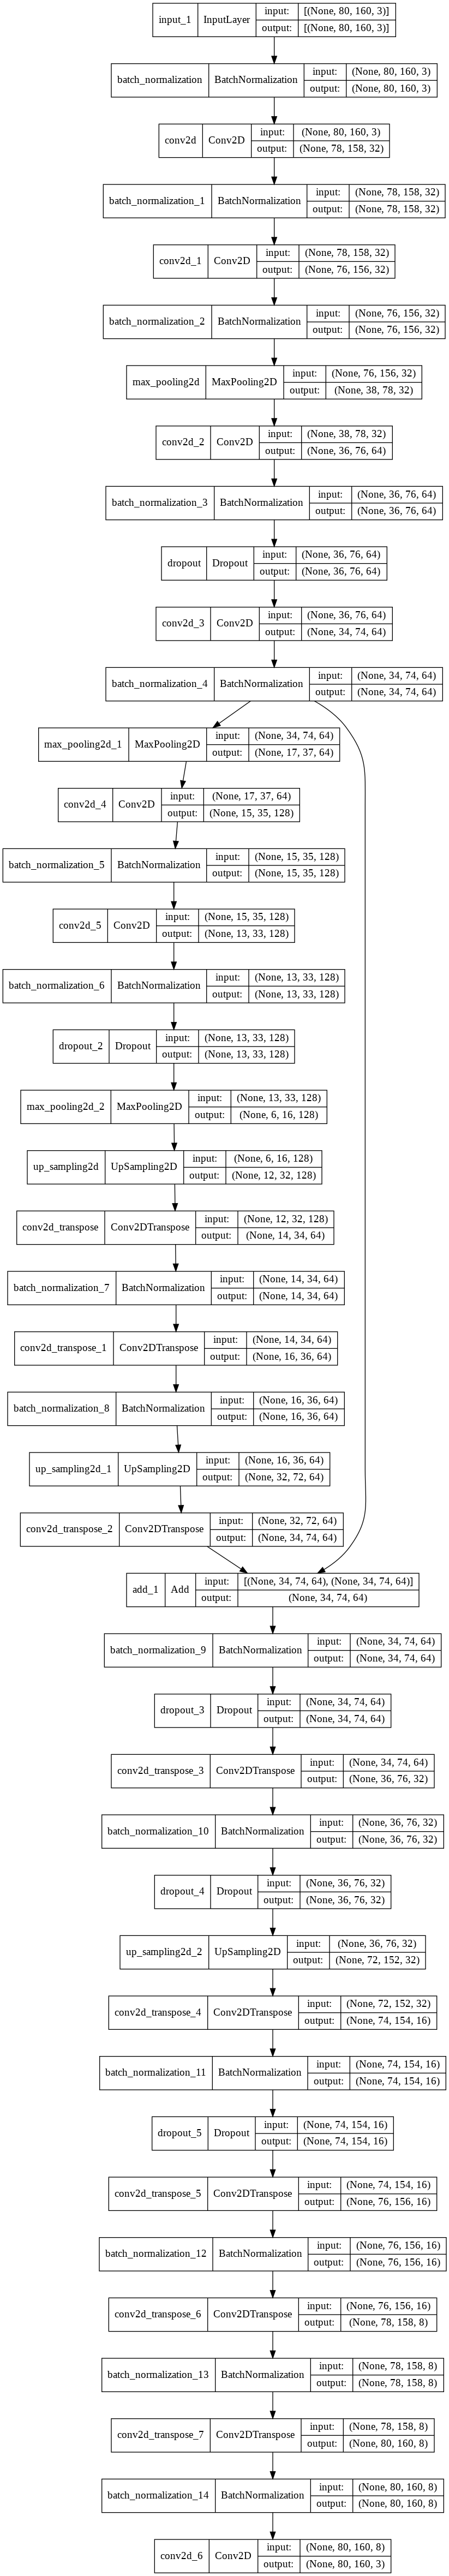

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
### Installing Wandb for Logging
!pip3 install wandb

     |████████████████████████████████| 1.7 MB 4.0 MB/s 
     |████████████████████████████████| 180 kB 82.6 MB/s 
     |████████████████████████████████| 97 kB 10.0 MB/s 
     |████████████████████████████████| 143 kB 92.3 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=c5a4cd3a28b22a6b776c2f03e085018b0f4c11d9bcee14386055e0d4239794aa
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=0f885a2a92869a0b5cb1374e5a82f0a3f17f31ff0d12840c376c9da1e4a45757
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
# Wandb Loggers
import wandb
from wandb.keras import WandbCallback
wandb.init(project="image_segmentation_exp", entity="udaygirish")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Model Training

In [ ]:
batch_size = 32
epochs = 15
pool_size = (2, 2)
learning_rate= 0.001
steps_per_epoch=len(X_train)/batch_size
input_shape = X_train.shape[1:]

In [ ]:
# Using a generator to help the model use less data
# Channel shifts help with shadows slightly
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=20000,
    end_learning_rate = 1e-5,
    power=0.5)


wandb.config = {
 "learning_rate" : lr_schedule,
 "epochs" : epochs,
 "batch_size" : 32
}


optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
class LRLogger(tf.keras.callbacks.Callback):
    def __init__(self, optimizer):
        super(LRLogger, self).__init__
        self.optimizer =optimizer
    
    def on_epoch_end(self,epoch,logs):
        lr = self.optimizer.learning_rate(epoch)
        wandb.log({"lr":lr}, commit = False)
        
        
filepath = "./weights.best_{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_f = keras.callbacks.ModelCheckpoint(filepath,monitor = "val_loss", verbose=1, save_best_only=False, mode="max")

callbacks = [
    keras.callbacks.ModelCheckpoint("resnet_101_training/save_at_{epoch}.h5"), checkpoint_f,WandbCallback()
, LRLogger(optimizer) ]

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy", 
)

H = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=steps_per_epoch, 
          epochs=epochs, verbose=1, validation_data=(X_val, y_val), callbacks = callbacks)


Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f552f7d3110>> (for pre_run_cell):


Exception: ignored

Exception: ignored

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f552f7d3110>> (for post_run_cell):


Exception: ignored

dict_keys(['loss', 'val_loss'])


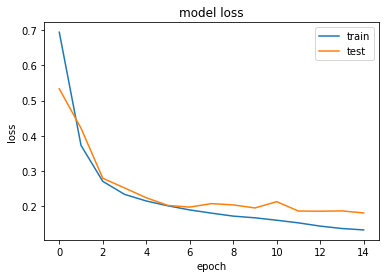

In [ ]:
# Plot Training Results 
print(H.history.keys())
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Test the model and build a General Prediction Pipeline

In [ ]:
def rgb_channel(img, thresholding=False, thresh=230):
    """Threshold the re-drawn images"""
    image = np.copy(img)
    if thresholding:
        ret, image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    return R,G,B

In [ ]:
def run(input_image):
    h,w,d = input_image.shape
    network_image = input_image.copy()
    network_image = cv2.resize(network_image, (160,80), interpolation=cv2.INTER_AREA)
    network_image = network_image[None,:,:,:]
    prediction = model.predict(network_image)[0]*255
    R,G,B = rgb_channel(prediction)
    blank = np.zeros_like(R).astype(np.uint8)
    lane_image = np.dstack((R,blank, B))
    lane_image = cv2.resize(lane_image, (w,h))
    result = cv2.addWeighted(input_image, 1, lane_image.astype(np.uint8), 1, 0)
    return result

Text(0.5, 1.0, 'Drawn Prediction')

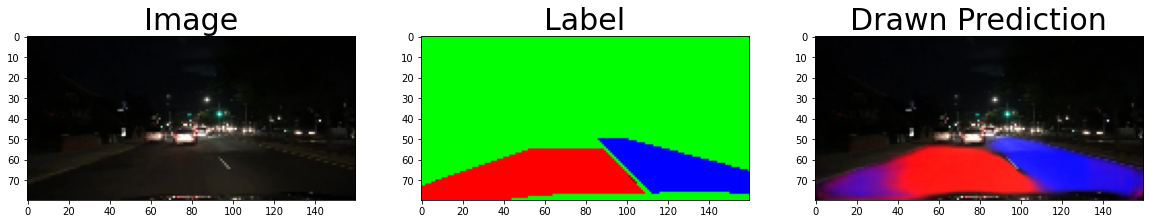

In [ ]:
index = random.randint(0,len(images))

img_test = run(images[index])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(images[index].squeeze())
ax1.set_title('Image', fontsize=30)
ax2.imshow(labels[index].squeeze())
ax2.set_title('Label', fontsize=30)
ax3.imshow(img_test)
ax3.set_title("Drawn Prediction", fontsize=30)

### Run on a Video 
#### Check Results Post

In [ ]:
video_path = "videos/videos/project_video.mp4"

In [ ]:
cap = cv2.VideoCapture(video_path)
out = cv2.VideoWriter('video_out.avi', cv2.VideoWriter_fourcc(*'DIVX'),15, (160,80))
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    result_image = run(frame)

    out.write(result_image)
 
cap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
# Using MoviePy editor
from moviepy.editor import VideoFileClip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2719744/45929032 bytes (5.9%)6955008/45929032 bytes (15.1%)11214848/45929032 bytes (24.4%)15499264/45929032 bytes (33.7%)19841024/45929032 bytes (43.2%)24076288/45929032 bytes (52.4%)28229632/45929032 bytes (61.5%)32366592/45929032 bytes (70.5%)36601856/45929032 bytes (79.7%)40787968/45929032 bytes (88.8%)45039616/45929032 bytes (98.1%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

In [ ]:
clip = VideoFileClip(video_path)
white_clip = clip.fl_image(run)
%time white_clip.write_videofile("test_project_out.mp4",audio=False)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f552f7d3110>> (for pre_run_cell):


Exception: ignored

[MoviePy] >>>> Building video test_project_out.mp4
[MoviePy] Writing video test_project_out.mp4


  1%|          | 13/1261 [00:00<01:05, 19.12it/s]Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/wandb_run.py", line 152, in check_network_status
    status_response = self._interface.communicate_network_status()
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface.py", line 125, in communicate_network_status
    resp = self._communicate_network_status(status)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_shared.py", line 388, in _communicate_network_status
    resp = self._communicate(req, local=True)
  File "/usr/local/lib/python3.7/dist-packages/wandb/sdk/interface/interface_shared.py", line 213, in _communicate
    return self._communicate_async(rec, local=local).g

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_project_out.mp4 

CPU times: user 1min 23s, sys: 5.51 s, total: 1min 28s
Wall time: 1min 26s
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f552f7d3110>> (for post_run_cell):


Exception: ignored